<a href="https://colab.research.google.com/github/kimyuji/AI_Assignment/blob/main/MNIST_Classifier_with_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제3 MNIST classifier 만들기

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

### 0. Device Configuration and define Hyperparameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
sequence_length = 28 # 고정
input_size = 28 # 고정
num_layers = 10 # 크면 안 좋음 overfitting인듯 (원래5엿음)
num_classes =10 # label 종류
batch_size = 50 # 고정 #50이 제일 적당한 듯 
num_epochs = 15

### 1. Load Data

In [ ]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)
test_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=False,
                                        transform=transforms.ToTensor(),
                                        download=True)

### 2. Define DataLoader

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True) #shuffle 필수

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

### 3. Define a Model

In [ ]:
class RNN(nn.Module):
  def __init__(self, intput_size, num_layers, num_classes, drop_percent=0.0, model='RNN', hidden_size=200):
    super(RNN, self).__init__()
    self.model=model
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # batch_first: dataloader와 차원을 맞춰주기 위해 size에서 순서가 다르기 때문에!!!
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.dropout = nn.Dropout(drop_percent)

  def forward(self, x):

   # 원하는 모델 골라쓰기!
    if self.model == "RNN":
      out, hidden = self.rnn(x)
    elif self.model == "LSTM":
      out, _ = self.lstm(x)
    elif self.model == "GRU":
      out, hidden = self.gru(x)
    else:
      print("choose a model in ['RNN', 'LSTM', 'GRU']")
      raise # 에러 발생시킴

    out = self.dropout(out)
    out = self.fc(out[:,-1,:]) # 마지막것만
    return out


### 4. Define Train/Test function


In [ ]:
# Train Function
def train(model, train_loader, optimizer, criterion, model_name):
  total_step = len(train_loader)
  error=[]
  for epoch in range(num_epochs):
    for i, (image, label) in enumerate(train_loader):
      image = image.reshape(-1, sequence_length, input_size).to(device)
      label = label.to(device)

      # Forward
      output = model(image)
      loss = criterion(output, label)

      # Backward and optimize
      batch_loss = 0.0
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
      error.append(batch_loss)

      if (i+1) % 600 == 0:
        print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  torch.save(model.state_dict(),"{}.pth".format(model_name)) # 모델 저장
  return error

In [ ]:
 # TEST Function
 def test(model, test_loader):
  model.eval()
  with torch.no_grad(): #gradient 계산x
    correct = 0

    for image, label in test_loader:
      image = image.reshape(-1, sequence_length, input_size).to(device)
      label = label.to(device)
      output = model(image)
      _, pred = torch.max(output.data, 1) # prediction 값만 사용, 10개 중 가장 높은 값
      correct += (pred == label).sum().item()

    print('Test Accuracy of RNN model on the {} test images: {}%'.format(len(test_data), 100 * correct / len(test_data)))

### 5-1. RNN

In [ ]:
rnn_model = RNN(input_size, num_layers, num_classes, model='RNN', hidden_size=150).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.0005)

In [ ]:
trained_error = train(rnn_model, train_loader, optimizer, criterion,  model_name="rnn_학번")

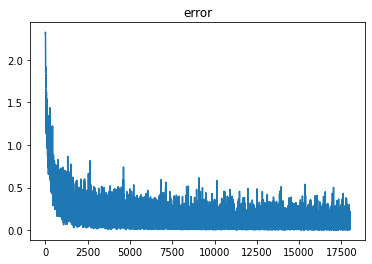

In [ ]:
plt.plot(trained_error)
plt.title('error')
plt.show()

In [ ]:
rnn_model.load_state_dict(torch.load('{}_학번.pth'.format("rnn"))) # 모델 불러오기 
test(rnn_model, test_loader)

Test Accuracy of RNN model on the 10000 test images: 97.34%


### 5-2. LSTM

In [ ]:
lstm_model = RNN(input_size, num_layers, num_classes, model='LSTM', hidden_size=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005)

In [ ]:
trained_error = train(lstm_model, train_loader, optimizer, criterion,  model_name="lstm_학번")

Epoch [1/15], Step[600/1200], Loss:1.3504
Epoch [1/15], Step[1200/1200], Loss:0.7210
Epoch [2/15], Step[600/1200], Loss:0.8764
Epoch [2/15], Step[1200/1200], Loss:0.4588
Epoch [3/15], Step[600/1200], Loss:0.4465
Epoch [3/15], Step[1200/1200], Loss:0.2067
Epoch [4/15], Step[600/1200], Loss:0.1599
Epoch [4/15], Step[1200/1200], Loss:0.5985
Epoch [5/15], Step[600/1200], Loss:0.1302
Epoch [5/15], Step[1200/1200], Loss:0.0522
Epoch [6/15], Step[600/1200], Loss:0.3100
Epoch [6/15], Step[1200/1200], Loss:0.0459
Epoch [7/15], Step[600/1200], Loss:0.0765
Epoch [7/15], Step[1200/1200], Loss:0.0960
Epoch [8/15], Step[600/1200], Loss:0.1145
Epoch [8/15], Step[1200/1200], Loss:0.2322
Epoch [9/15], Step[600/1200], Loss:0.0503
Epoch [9/15], Step[1200/1200], Loss:0.0238
Epoch [10/15], Step[600/1200], Loss:0.1534
Epoch [10/15], Step[1200/1200], Loss:0.0307
Epoch [11/15], Step[600/1200], Loss:0.0089
Epoch [11/15], Step[1200/1200], Loss:0.0377
Epoch [12/15], Step[600/1200], Loss:0.1328
Epoch [12/15], Ste

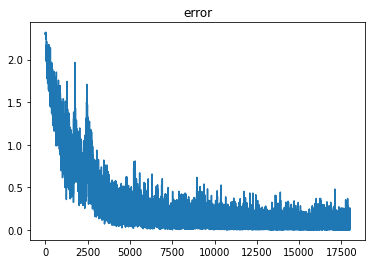

In [ ]:
plt.plot(trained_error)
plt.title('error')
plt.show()

In [ ]:
lstm_model.load_state_dict(torch.load('{}_학번.pth'.format("lstm")))
test(lstm_model, test_loader)

Test Accuracy of RNN model on the 10000 test images: 98.36%


### 5-3. GRU

In [ ]:
gru_model = RNN(input_size, num_layers, num_classes, model='GRU', hidden_size=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

In [ ]:
trained_error = train(gru_model, train_loader, optimizer, criterion,  model_name="gru_학번")

Epoch [1/15], Step[600/1200], Loss:0.2542
Epoch [1/15], Step[1200/1200], Loss:0.0353
Epoch [2/15], Step[600/1200], Loss:0.2478
Epoch [2/15], Step[1200/1200], Loss:0.0104
Epoch [3/15], Step[600/1200], Loss:0.1558
Epoch [3/15], Step[1200/1200], Loss:0.1698
Epoch [4/15], Step[600/1200], Loss:0.1061
Epoch [4/15], Step[1200/1200], Loss:0.0214
Epoch [5/15], Step[600/1200], Loss:0.0504
Epoch [5/15], Step[1200/1200], Loss:0.0167
Epoch [6/15], Step[600/1200], Loss:0.0508
Epoch [6/15], Step[1200/1200], Loss:0.0062
Epoch [7/15], Step[600/1200], Loss:0.0862
Epoch [7/15], Step[1200/1200], Loss:0.0061
Epoch [8/15], Step[600/1200], Loss:0.1073
Epoch [8/15], Step[1200/1200], Loss:0.1322
Epoch [9/15], Step[600/1200], Loss:0.0126
Epoch [9/15], Step[1200/1200], Loss:0.0081
Epoch [10/15], Step[600/1200], Loss:0.0054
Epoch [10/15], Step[1200/1200], Loss:0.0057
Epoch [11/15], Step[600/1200], Loss:0.0670
Epoch [11/15], Step[1200/1200], Loss:0.1239
Epoch [12/15], Step[600/1200], Loss:0.0679
Epoch [12/15], Ste

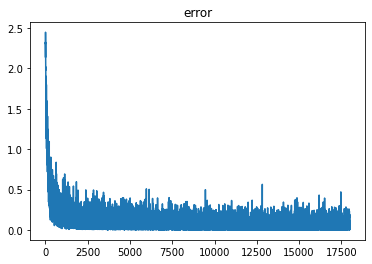

In [ ]:
plt.plot(trained_error)
plt.title('error')
plt.show()

In [ ]:
gru_model.load_state_dict(torch.load('{}_학번.pth'.format("gru")))
test(gru_model, test_loader)

Test Accuracy of RNN model on the 10000 test images: 98.4%
